In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from numpy import genfromtxt



In [117]:
priceFile = 'pricedata_LMP_temp.csv'
nameFile = 'node_names.csv'
dataList = formatData(priceFile, nameFile)

In [118]:
print len(dataList)

26964


In [139]:
models = list()
epsList = list()

for eps in range (5, 30, 5):
    minSamples = 150
    models.append(calculateModelEntropy(dataList, eps, minSamples))
    epsList.append(eps)


In [144]:
minSamplesList = list()
for eps in range (5, 30, 5):
        minSamplesList.append(150)

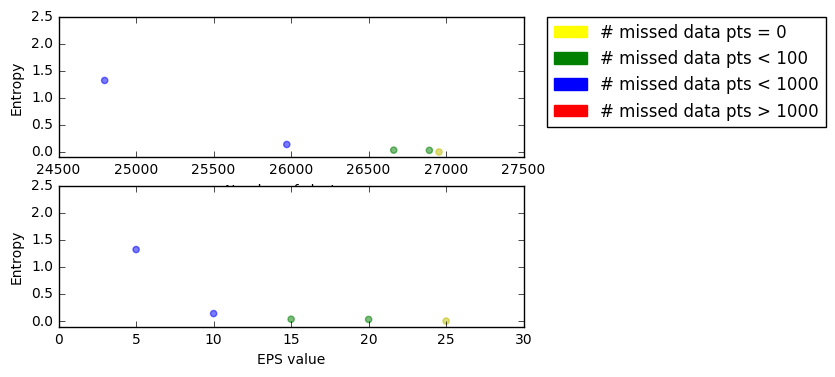

In [147]:
import matplotlib.patches as mpatches
numClusters = list()
numNoise = list()
entropy = list()
noiseColor = list()
for clusters in range(0, len(models), 1):
    numClusters.append(models[clusters][0])
    entropy.append(models[clusters][2])
    if(models[clusters][1] == 0):
        noiseColor.append('y')
    elif(models[clusters][1]  < 100):
        noiseColor.append('g')
    elif(models[clusters][1]  < 1000):
        noiseColor.append('b')
    else:
        noiseColor.append('r')
        
green_patch = mpatches.Patch(color='green', label='# missed data pts < 100')       
blue_patch = mpatches.Patch(color='blue', label='# missed data pts < 1000')
red_patch = mpatches.Patch(color='red', label='# missed data pts > 1000')
yellow_patch = mpatches.Patch(color='yellow', label='# missed data pts = 0')

plt.subplot(2, 1, 1)
plt.legend(handles=[yellow_patch, green_patch, blue_patch, red_patch], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Number of clusters')
plt.ylabel('Entropy')
plt.ylim(-.1,2.5)
plt.scatter(numClusters, entropy, color = noiseColor, alpha = 0.3)
plt.subplot(2, 1, 2)
plt.xlabel('EPS value')
plt.ylabel('Entropy')
plt.ylim(-.1,2.5)
plt.scatter(epsList, entropy, color = noiseColor, alpha = 0.3)
#plt.subplot(3, 1, 3)
#plt.xlabel('Min. # in sample')
#plt.ylabel('Entropy')
#plt.ylim(-.1,2.5)
#plt.scatter(minSamplesList, entropy, color = noiseColor, alpha = 0.3)
#plt.tight_layout()
plt.show()

In [143]:

with open('C:\\Users\\Emily\\Desktop\\allData_DBS_entropy_lowEPS_minSamples150.csv','w') as f:
    f.write('Entropy, Number of Clusters, EPS Value, Min # in sample\n')
    for i in  range(0, len(entropy), 1):
        # write into a file
        f.write('%f, %d, %f, %d\n' % (entropy[i], numClusters[i], epsList[i], minSamplesList[i]))


In [57]:
def calculateModelEntropy(dataList, epsVal, minSamples):
    dataArray = formatDataArray(dataList)
    clusters = clustering(dataArray, epsVal, minSamples)
    labeledNodes = makeLabeledNodeList(clusters, dataArray)[0]
    numberOfNoise = len(makeLabeledNodeList(clusters, dataArray)[1])
    modelEntropy = totalEntropy(clusters.components_, labeledNodes)
    numClusters = numberOfClusters(clusters)
    modelResults = list()
    modelResults.append(numClusters)
    modelResults.append(numberOfNoise)
    modelResults.append(modelEntropy)
    return modelResults
    

In [114]:
def formatData(priceDataFile, nodeNamesFile):
    file = open(priceDataFile, 'rb')
    nodes = pd.read_csv(file, parse_dates = True, infer_datetime_format = True)
    # read file containing node names
    file = open(nodeNamesFile, 'rb')
    nodeNames = pd.read_csv(file, parse_dates = True, infer_datetime_format = True)
    
    masterListNodes = list()

    for n in range(0, len(nodeNames), 1):
        node = makeNodeMasterList(nodeNames['Names'][n], nodes)
        for h in range (0, 24, 2):
            masterListNodes.append(node[h])

    return masterListNodes

    

In [20]:
def formatDataArray(masterListNodes):
    nodeArray = np.asarray(masterListNodes)
    nsamples, nx, ny = nodeArray.shape
    d2_nodeArray = nodeArray.reshape((nsamples,nx*ny))
    return d2_nodeArray

In [17]:
def makeNodeMasterList(nodeName, nodes):
    node = list()
    dayCounter = 0
    startIndex = 0
    lastIndex = 24
    for totalDays in range(0, len(nodes[nodeName])/24, 1):
        node.append(list())
    for d in range (0, len(nodes[nodeName])/24, 1):
        #print nodes[nodeName][d]
        node[dayCounter].append(nodes[nodeName][startIndex:lastIndex])
        startIndex = startIndex + 24
        lastIndex = lastIndex + 24
        dayCounter = dayCounter + 1
    return node

In [73]:
masterListNodes = list()

for n in range(0, 50, 1):
    node = makeNodeMasterList(nodeNames['Names'][n])
    for h in range (0, 24, 2):
        masterListNodes.append(node[h])
    
print "done"

done


In [90]:
nodeArray = np.asarray(masterListNodes)
nsamples, nx, ny = nodeArray.shape
d2_nodeArray = nodeArray.reshape((nsamples,nx*ny))
print d2_nodeArray.shape

(600L, 24L)


In [86]:
def clustering(data, epsVal, minSamplesVal):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps = epsVal, min_samples=minSamplesVal).fit(data)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    components = db.components_
        # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    #print('Estimated number of clusters: %d' % len(components))
    
    return db
 


In [41]:
def numberOfClusters(db):
    return len(db.components_)

In [54]:
def makeLabeledNodeList(db, data):
    labeledNodes = list() 
    noisyNodes = list()
    labels = db.labels_
    components = db.components_
    for i in range (0, len(components), 1):
        labeledNodes.append(list())

    for i in range(0, len(labels), 1):
        if(data[i] not in components):
            if (labels[i] == -1):
                noisyNodes.append(data[i])
            else:
                labeledNodes[labels[i]].append(data[i])
    allNodes = list()
    allNodes.append(labeledNodes)
    allNodes.append(noisyNodes)
    return allNodes
    


In [173]:
labeledNodesArray = np.asarray(labeledNodes)
#nsamples, nx, ny = nodeArray.shape
#d2_nodeArray = nodeArray.reshape((nsamples,nx*ny))
print labeledNodesArray.shape

(121L,)


In [176]:
print distance(db.components_[0], db.components_[1])

25.1391058702


In [148]:

print sigmaSquared(components[0], labeledNodes[0])

1178.43743338


In [8]:
import math
def distance(pointA, pointB):
    difSquared = 0
    for i in range (0, len(pointA), 1):
        difSquared = difSquared + math.pow((pointA[i]-pointB[i]), 2)
    return math.sqrt(difSquared)
        

In [9]:
def sigmaSquared(clusterCenter, pointsInCluster):
    sumOfDistanceSquared = 0
    for point in pointsInCluster:
        sumOfDistanceSquared = sumOfDistanceSquared + math.pow(distance(clusterCenter, point), 2)
    return sumOfDistanceSquared/len(pointsInCluster)

In [10]:
def probability(x, c, sigmaSquared):
    '''
    Inputs :
    - x : shape (1, n_features) : coordinates of one data point in the space of features 
    (here, features are hourly price values )
    - c : shape (1, n_features) : coordinates of centroid of the cluster to which x belongs
    - sigma : standard deviation of the cluster
    
    Output :
    - pij : scalar. probability of having xj in cluster i 
    '''
    p = (1/np.sqrt(2*np.pi*(sigmaSquared)))*np.exp(-distance(x,c)/(2*(sigmaSquared)))
    return p

In [11]:
def clusterEntropy(clusterCenter, pointsInCluster):
    entropy = 0
    sig = sigmaSquared(clusterCenter, pointsInCluster)
    for point in pointsInCluster:
        prob = probability(point, clusterCenter, sig)
        entropy = entropy + (-(prob * math.log(prob)))
    return entropy

In [153]:
clusterEntropy(components[0], labeledNodes[0])

0.46071286058729077

In [59]:
def totalEntropy(components, labeledNodes):
    entropy = 0
    for i in range(0, len(components), 1):
        if(len(labeledNodes[i]) > 0):
            entropy = entropy + (clusterEntropy(components[i], labeledNodes[i]) / len(labeledNodes[i]))
    return entropy

In [175]:
print totalEntropy(components, labeledNodes)

1.09465765915
